# Feature Engineering for Time-Series Forecasting  
## Transforming Sequential Data into Supervised Learning Format (with Daily Temperature Example)

In this notebook, we explore how to **prepare time-series data for machine learning forecasting** by transforming it into a **supervised learning format**. 

We will:

- Introduce the theory behind:
  - **Lag features**
  - **Window-based features**
  - **Rolling (moving) statistics**
- Use a real-world dataset:  
  **Daily Minimum Temperatures in Melbourne, Australia (1981–1990)**.
- Build a forecasting model using:
  - Feature engineering with `pandas`
  - A **Random Forest Regressor** from `scikit-learn`
- Evaluate and visualize:
  - Predictions vs. actual values
  - A simple future forecast

---

### Why Feature Engineering for Time Series?

Most machine learning models (Random Forests, Gradient Boosting, Linear Regression, etc.) assume that **each row in the dataset is independent**. However, time-series data violates this assumption because:

> What happens today depends on what happened in the past.

To use ML models effectively for forecasting, we must **encode temporal information** into features that the model can learn from.

We achieve this by:

- Creating **lag features** (previous time steps as inputs)
- Creating **rolling features** (averages, standard deviations, etc. over moving windows)
- Structuring the data so that:
  - **Inputs (X)** = engineered features
  - **Target (y)** = value we want to forecast

We will now walk through both the **theory** and the **implementation** step by step.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

plt.style.use("default")

# Load Daily Minimum Temperatures dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=["Date"], index_col="Date")

df.head()


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


## Dataset Description: Daily Minimum Temperatures (Melbourne)

We use the **Daily Minimum Temperatures in Melbourne** dataset, originally compiled and published by the Australian Bureau of Meteorology and made widely available via Jason Brownlee’s time series repository.

- **Variable**: Daily minimum temperature (°C)  
- **Location**: Melbourne, Australia  
- **Time span**: 1981–1990  
- **Frequency**: Daily observations

We will treat this as a **univariate time series**, where:

- Input: Past temperature values (engineered as features)
- Output: Next-day temperature (target to predict)


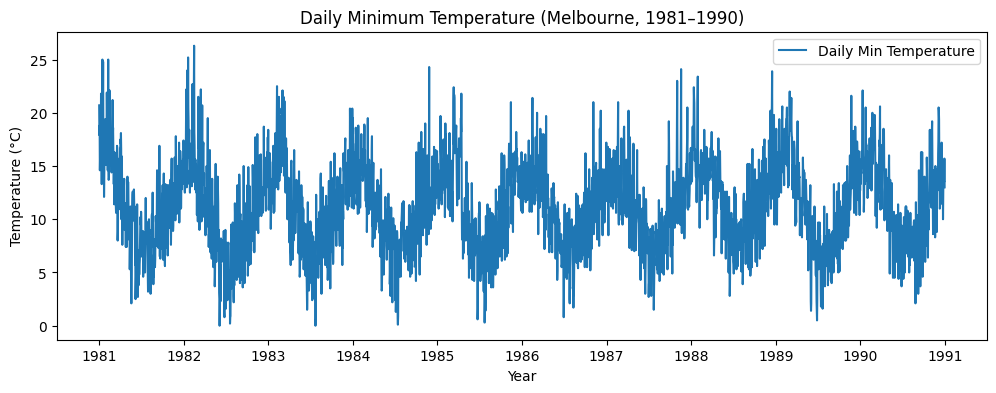

In [3]:
plt.figure(figsize=(12,4))
plt.plot(df["Temp"], label="Daily Min Temperature")
plt.title("Daily Minimum Temperature (Melbourne, 1981–1990)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


## From Time-Series to Supervised Learning

Traditional time-series methods like ARIMA or Exponential Smoothing explicitly model temporal structure. Machine learning models, on the other hand, see the world as:

> **Rows of features → Predict a target**

They **do not** automatically understand the order of time or the idea of "yesterday" versus "today." To make them work on time-series, we must **manually encode** temporal structure.

### Key idea

We convert the time series:

\[
y_t, y_{t-1}, y_{t-2}, \dots
\]

into a supervised format:

\[
X_t = [y_{t-1}, y_{t-2}, \dots], \quad y_t = \text{current value}
\]

This is done via:

1. **Lag features** – previous values like \( y_{t-1}, y_{t-2}, \dots \)  
2. **Window features** – a chunk of several past values treated as inputs  
3. **Rolling statistics** – summaries (mean, std, min, max) over past windows

These features allow ML models to approximate concepts like:

- **Autocorrelation** (how strongly a value depends on past values)
- **Trend** (long-term upward or downward movement)
- **Seasonality** (repeating patterns over daily/weekly/yearly cycles)
- **Volatility** (how variable the series is over time)

Next, we will implement these ideas on our temperature series.


In [4]:
df_features = df.copy()

# Create lag features: yesterday, 2 days ago, 3 days ago
df_features["lag_1"] = df_features["Temp"].shift(1)
df_features["lag_2"] = df_features["Temp"].shift(2)
df_features["lag_3"] = df_features["Temp"].shift(3)

df_features.head(7)


,Temp,lag_1,lag_2,lag_3
Date,,,,
1981-01-01,20.7,NaN,NaN,NaN
1981-01-02,17.9,20.7,NaN,NaN
1981-01-03,18.8,17.9,20.7,NaN
1981-01-04,14.6,18.8,17.9,20.7
1981-01-05,15.8,14.6,18.8,17.9
1981-01-06,15.8,15.8,14.6,18.8
1981-01-07,15.8,15.8,15.8,14.6


## Lag Features: Capturing Autocorrelation

A **lag feature** is simply the value of the time series from a previous time step.

- `lag_1` = temperature yesterday (\( y_{t-1} \))
- `lag_2` = temperature two days ago (\( y_{t-2} \))
- `lag_3` = temperature three days ago (\( y_{t-3} \))

If the series is **autocorrelated** (today's temperature depends on recent temperatures), these lags give the model useful "memory."

For example, we convert:

| Day | Temp |
|-----|------|
| 1   | 20   |
| 2   | 21   |
| 3   | 19   |
| 4   | 23   |

into:

| Target (Temp today) | lag_1 | lag_2 |
|---------------------|-------|-------|
| 19 (Day 3)          | 21    | 20    |
| 23 (Day 4)          | 19    | 21    |

Now a standard regressor can learn:

\[
\text{Temp today} = f(\text{lag_1}, \text{lag_2}, \dots)
\]

We choose 3 lags here as a simple example. In practice, the number and size of lags are often guided by:

- Domain knowledge (e.g., weather patterns, business cycles)
- Autocorrelation plots (ACF/PACF)
- Validation performance.


In [5]:
# Rolling window features (trend & volatility)
df_features["roll_mean_7"] = df_features["Temp"].rolling(window=7).mean()
df_features["roll_std_7"] = df_features["Temp"].rolling(window=7).std()
df_features["roll_mean_30"] = df_features["Temp"].rolling(window=30).mean()

df_features.tail(10)


,Temp,lag_1,lag_2,lag_3,roll_mean_7,roll_std_7,roll_mean_30
Date,,,,,,,
1990-12-22,13.2,13.1,15.4,14.7,14.442857,1.468397,14.086667
1990-12-23,13.9,13.2,13.1,15.4,14.485714,1.443870,14.200000
1990-12-24,10.0,13.9,13.2,13.1,13.928571,2.240323,14.163333
1990-12-25,12.9,10.0,13.9,13.2,13.314286,1.723783,14.160000
1990-12-26,14.6,12.9,10.0,13.9,13.300000,1.710750,14.216667
1990-12-27,14.0,14.6,12.9,10.0,13.100000,1.492202,14.390000
1990-12-28,13.6,14.0,14.6,12.9,13.171429,1.504121,14.353333
1990-12-29,13.5,13.6,14.0,14.6,13.214286,1.509336,14.313333
1990-12-30,15.7,13.5,13.6,14.0,13.471429,1.775495,14.413333


## Rolling Features: Trend and Volatility in Motion

**Rolling (moving) statistics** summarize behavior over a recent window:

- `roll_mean_7`: Average temperature over the last 7 days  
- `roll_std_7`: Variability (standard deviation) over the last 7 days  
- `roll_mean_30`: Smoothed trend over the last 30 days  

These features:

1. **Capture trend**  
   - A rolling mean smooths short-term noise and emphasizes longer patterns.

2. **Capture volatility**  
   - Rolling standard deviation indicates how stable or variable recent days have been.

3. **Act like a low-pass filter**  
   - They reduce short-term fluctuations and highlight underlying structure.

In classical time-series analysis, similar ideas appear in:

- Moving averages  
- Decomposition into trend + seasonal + residual components  

Here, we encode them as numeric features that a machine learning model can directly use.


In [6]:
# Drop initial rows with NaN values caused by shifting/rolling
df_model = df_features.dropna()

# Features (X) and target (y)
X = df_model.drop("Temp", axis=1)
y = df_model["Temp"]

X.head(), y.head()


(            lag_1  lag_2  lag_3  roll_mean_7  roll_std_7  roll_mean_30
 Date                                                                  
 1981-01-30   15.5   17.2   19.4    16.914286    1.620112     17.790000
 1981-01-31   15.1   15.5   17.2    16.828571    1.690872     17.613333
 1981-02-01   15.4   15.1   15.5    16.657143    1.787789     17.526667
 1981-02-02   15.3   15.4   15.1    16.671429    1.807129     17.526667
 1981-02-03   18.8   15.3   15.4    17.028571    2.536214     17.770000,
 Date
 1981-01-30    15.1
 1981-01-31    15.4
 1981-02-01    15.3
 1981-02-02    18.8
 1981-02-03    21.9
 Name: Temp, dtype: float64)

## Time-Aware Train–Test Split (No Shuffling)

In standard machine learning tasks, we often randomly shuffle the data before splitting into train and test sets.  

For time-series, **we must respect time order**:

- Training data should contain **earlier** time periods
- Test data should contain **later** time periods

Shuffling breaks the temporal structure and can lead to unrealistically optimistic performance estimates.

We’ll use a simple split where:

- The first ~80% of timesteps → training set  
- The last ~20% of timesteps → test set  

We also make sure **not to shuffle**.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

len(X_train), len(X_test)


(2896, 725)

In [8]:
# Naive baseline: predict "tomorrow" as "today" (lag_1)
# Align y_test with corresponding lag_1 from X_test
naive_preds = X_test["lag_1"].values
naive_mae = mean_absolute_error(y_test, naive_preds)
naive_mae


1.9504827586206894

## Baseline Model: Naive "Yesterday = Today"

Before using any machine learning model, it's important to define a **baseline**.

A common naive baseline in time-series forecasting is:

> **Predict tomorrow's value as today's value**.

In feature terms, this is equivalent to using only `lag_1` as the prediction.

We just computed the **Mean Absolute Error (MAE)** of this naive approach. Our machine learning model should **beat this baseline**; otherwise, we haven't added any value.


In [9]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_mae


1.544651954022989

## Comparing Model Performance

We now have two MAE values:

- **Naive baseline MAE** (yesterday = today)
- **Random Forest MAE** (using lags + rolling features)

If the Random Forest MAE is **lower** than the naive MAE, we can conclude:

- Our **feature engineering** (lags + rolling statistics) is helping.
- The model is learning meaningful temporal patterns beyond trivial persistence.

This highlights the value of transforming the raw time series into a **feature-rich supervised learning dataset**.


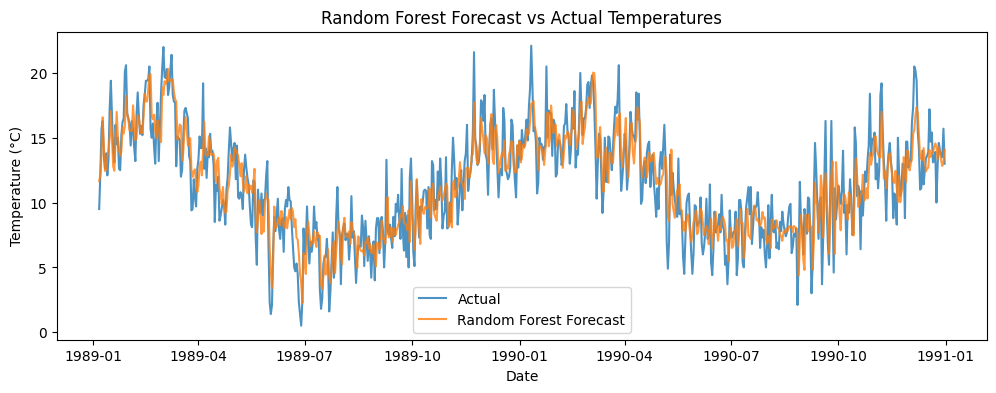

In [10]:
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label="Actual", alpha=0.8)
plt.plot(y_test.index, rf_preds, label="Random Forest Forecast", alpha=0.8)
plt.title("Random Forest Forecast vs Actual Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


## Visualizing Forecasts vs Actuals

The plot shows:

- **Blue line (Actual)**: True daily minimum temperature.
- **Orange line (Forecast)**: Random Forest predictions using our engineered features.

We can visually inspect:

- How closely the forecast follows the actual series.
- Where the model underestimates or overestimates.
- Whether it captures the **general pattern** (trend and local variation).

This visual check complements the MAE metric and helps us reason about whether the model behaves sensibly over time.


In [11]:
# Take the most recent row of feature data
last_row = df_features.tail(1)

# Drop the target column (Temp) to form feature vector
X_future = last_row.drop("Temp", axis=1)

future_forecast = rf_model.predict(X_future)[0]
future_forecast


14.075333333333344

## Forecasting the Next Day's Temperature

To forecast the **next day**:

1. We use the most recent available data:
   - Last few days' temperatures (`lag_1`, `lag_2`, `lag_3`)
   - Latest rolling statistics (`roll_mean_7`, `roll_std_7`, `roll_mean_30`)
2. Feed this final feature vector into the trained Random Forest model.
3. Obtain a **single predicted value** representing tomorrow's forecast.

In production, this process would be automated and repeated each day, with:

- New observations added to the dataset
- Rolling features updated
- Model either:
  - Retrained periodically, or  
  - Used with updated features (if stable enough)


## Summary and Key Takeaways

In this notebook, we demonstrated how to **prepare time-series data for machine learning forecasting** using **feature engineering**.

### Conceptual Takeaways

- **Time-series → Supervised Learning**  
  Machine learning models require rows of features and a target. We used lag and rolling features to convert a temperature time-series into a supervised dataset.

- **Lag Features**  
  Provide the model with memory of recent values (e.g., yesterday, 2 days ago, 3 days ago).

- **Rolling Features**  
  Capture local trend and volatility using moving averages and standard deviations.

- **Baseline vs Model**  
  Always compare against a naive baseline (such as "tomorrow = today") to justify the added complexity of your model.

- **Time-Aware Train/Test Split**  
  We preserved temporal ordering by not shuffling data, ensuring a realistic evaluation.

### Practical Takeaways

- You can apply the same workflow to:
  - Stock prices
  - Energy consumption
  - Web traffic
  - Sales demand
  - Sensor readings
- Feature engineering often matters **more** than the choice of algorithm.
- This pipeline is a foundation you can extend with:
  - More lags and windows
  - Calendar features (day of week, month, holidays)
  - External variables (weather, promotions, events)
  - More advanced models (XGBoost, LightGBM, LSTMs, Transformers)

Overall, feature-based forecasting is a powerful and flexible way to bring time-series problems into the world of general-purpose machine learning.


## References

- Hyndman, R. J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed.). OTexts.  
- Brownlee, J. (2017). *Introduction to Time Series Forecasting with Python: How to Prepare Data and Develop Models to Predict the Future*. Machine Learning Mastery.  
- Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). *Time Series Analysis: Forecasting and Control* (5th ed.). Wiley.  
- Scikit-learn Developers. (2024). *Scikit-learn User Guide*. https://scikit-learn.org  
- pandas Development Team. (2024). *pandas Documentation*. https://pandas.pydata.org  
- Dataset:  
  J. Brownlee. (2017). *Daily Minimum Temperatures in Melbourne*. Retrieved from the Machine Learning Mastery Datasets Repository: https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv


# 📺 Video Demonstrations

Below are the supporting YouTube videos for each forecasting example.

---

## **Example 1 – Daily Temperature Forecasting**

### 🎥 Screen Recording  
https://youtu.be/nosSv-yzGv0  

### 🎬 Story-Style Explanation  
https://youtu.be/GQJqhdwn0vo  
